# Tratamiento de imágenes - 2024 - Entregable 2

# Fecha de entrega: 19/05/2024

### Importante:   
En todos los ejercicios se espera que se entregue comentarios sobre decisiones tomadas en la implementación así como un análisis de los resultados. Estos comentarios y análisis se pueden entregar en celdas de texto agregadas a los notebooks o en un informe aparte.

Para la entrega se sube un **zip** (no rar, ni otro formato) con:
* El notebook del entregable modificado. El notebook debe tener las celdas ejecutadas con las salidas correspondientes. Debe tener todo lo necesario para poder ser ejecutado nuevamente
* Todo el resto del contenido del zip del entregable. Si, para mostrar resultados, usan en el notebook imágenes propias, deben incluirlas en la carpeta **imagenes**  del zip. 
* El informe en pdf en caso de no incluir las discusiones dentro del notebook en celdas "Markdown", o si les resulta más sencillo realizar el análisis en un documento aparte.

No se deben incluir en el zip de la entrega las imágenes de prueba que están disponibles en la página web del curso. Se asumirá que esas imágenes están en un directorio y se hará referencia a dichas imágenes en forma relativa a ese directorio (ver la celda siguiente).

In [1]:
import os, cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread, imsave
from scipy.fftpack import fft2, ifft2, fftshift
import pandas as pd
from skimage import measure
from collections import Counter

# FORMAS DE VER LAS GRAFICAS --------------------
# ELEGIR UNA DE LAS OPCIONES Y DES-COMENTAR (sacar # de la linea)
# ----------------
# a) graficas en línea  entre las celdas (no interactivo)
%matplotlib inline
# ----------------
# b) graficas en línea  entre las celdas (interactivo)
# %matplotlib notebook
# ----------------
# c) graficas en ventanas externas (abre una ventana por cada figura)
# %matplotlib
# ----------------
# d) Si se usa "jupyter lab" en lugar de "jupyter notebook" usar %matplotlib widget en lugar de %matplotlib notebook
# requiere instalar el modulo "ipympl". Ver https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab#56416229
# %matplotlib widget
#---------------------------------------------------



# Directorio con la base de imágenes de prueba (las que están en la web de Timag)
# Ej. si usan la imagen trapo.jpg en el notebook no tienen que subirla al eva
# La llaman en el notebook en forma relativa a donde tengan esas imagenes:
#
# filename = os.path.join(dir_base_imagenes, 'trapo.jpg')
# I = imread(filename)
dir_base_imagenes = './imagenes'


## Transformaciones geométricas

### 1. Implementar una función que realice transformaciones proyectivas

Ej. function J=transformar(I, MatrizTransformación, TipoInterpolacion)  
donde MatrizTransformación es una matriz 3x3 y TipoInterpolacion puede ser 'bilineal' o 'vecino'

In [15]:
def bilineal(img, punto, color_de_fondo):
    """
    Dado un punto de coordenadas no necesariamente enteras y una imagen I,
    retorna la interpolación bilineal entre los cuatro pixeles de I más cercanos
    al punto de entrada.

    Args:
    - img (array 2D): Imagen de referencia para interpolar.
    - punto (tuple/list): coordenadas en imagen en formato: punto = (fila,columna) ó punto = [fila,columna]
    - color_de_fondo (int): en caso de que el punto está fuera de las dimensiones de la imagen,
    se le asigna este valor por defecto.

    Returns:
    valor_interpolado (int): valor interpolado en escala de grises para el punto.
    """

    filas, columnas = img.shape

    if (punto[0] < 0) or (punto[0] > filas - 1) or (punto[1] < 0) or (punto[1] > columnas - 1):
        return color_de_fondo

    i_1 = int(np.floor(punto[0]))
    i_2 = i_1 + 1
    j_1 = int(np.floor(punto[1]))
    j_2 = j_1 + 1

    dy = punto[0] - i_1
    dx = punto[1] - j_1

    valor_interpolado = (1-dy)*(1-dx)*img[i_1,j_1] + dx*(1-dy)*img[i_1,j_2] + dy*(1-dx)*img[i_2,j_1] + dx*dy*img[i_2,j_2]

    return int(valor_interpolado)

def vecino(img, punto, color_de_fondo):
    """
    Dado un punto de coordenadas no necesariamente enteras y una imagen I,
    retorna el nivel de gris correspondiente al pixel más cercano I.

    Args:
    - I (array 2D): Imagen de referencia para interpolar.
    - punto (tuple/list): coordenadas en imagen en formato: punto = (fila,columna) ó punto = [fila,columna]
    - color_de_fondo (int): en caso de que el punto está fuera de las dimensiones de la imagen,
    se le asigna este valor por defecto.

    Returns:
    valor_interpolado (int): valor interpolado en escala de grises para el punto.
    """

    filas, columnas = img.shape

    if (punto[0] < 0) or (punto[0] > filas - 1) or (punto[1] < 0) or (punto[1] > columnas - 1):
        return color_de_fondo

    i = int(np.round(punto[0]))
    j = int(np.round(punto[1]))

    return img[i,j]

def transformar(Img, T, tipo_interpolacion='vecino', color_de_fondo=0):
    """
    Aplicar una transformacion geometrica T a imagen I, especificando el tipo de interpolacion.

    Args:
    - I (array 2D): imagen a transformar.
    - T (array 2D): matriz de transformacion de tamaño 3x3.
    - tipo_interpolacion (str): interpolación a utilizar: 'vecino' más cercano (default) o 'bilineal'.
    - color_de_fondo (int): en caso de que el punto está fuera de las dimensiones de la imagen,
    se le asigna este valor por defecto.

    Returns:
    I_transformada (array 2D): imagen transformada

    """
    filas, columnas = Img.shape
    I_transformada = np.empty((filas, columnas))

    T_inv = np.linalg.inv(T)

    for i in range(filas):
        for j in range(columnas):
            punto = T_inv @ [j,i,1]
            punto = [punto[1]/punto[2], punto[0]/punto[2]]

            if tipo_interpolacion == 'vecino':
                I_transformada[i, j] = vecino(Img, punto, color_de_fondo)
            elif tipo_interpolacion == 'bilineal':
                I_transformada[i, j] = bilineal(Img, punto, color_de_fondo)

    return I_transformada

### 2. Usando la función transformar, mostrar ejemplos de transformaciones isométricas, afines y proyectivas  con diferentes interpolaciones

Parecido a lo que se muestra en estos ejemplos de scikit-image:  
https://scikit-image.org/docs/stable/auto_examples/transform/plot_transform_types.html


#### Dibujo de líneas

#### Mostrar una rotación con origen en vértice superior izquierdo de la imagen (origen de coordenadas) 

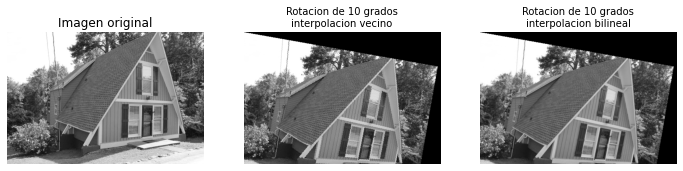

In [14]:
casa = cv2.imread(os.path.join(dir_base_imagenes, 'casa.jpg'), cv2.IMREAD_GRAYSCALE)

grados = 10
theta = np.radians(grados)
T = np.array([[np.cos(theta), -np.sin(theta), 0],
            [np.sin(theta),    np.cos(theta), 0],
            [0,                0,             1]])

casa_rotada_vecino = transformar(casa, T, tipo_interpolacion='vecino', color_de_fondo=0)
casa_rotada_bilineal = transformar(casa, T, tipo_interpolacion='bilineal', color_de_fondo=0)

fig, ax = plt.subplots(1, 3, figsize=(12,8))

ax[0].set_title(f'Imagen original')
ax[0].imshow(casa, cmap='gray')
ax[0].axis('off')

ax[1].set_title(f'Rotacion de {grados} grados\ninterpolacion vecino', fontsize=10)
ax[1].imshow(casa_rotada_vecino, cmap='gray')
ax[1].axis('off')

ax[2].set_title(f'Rotacion de {grados} grados\ninterpolacion bilineal', fontsize=10)
ax[2].imshow(casa_rotada_bilineal, cmap='gray')
ax[2].axis('off')

plt.show()

#### Mostrar una rotación con origen en el centro de la imagen
La transformación de rotación en el centro de la imagen puede calcularse como la composición de una traslación, una rotación y una traslación.  

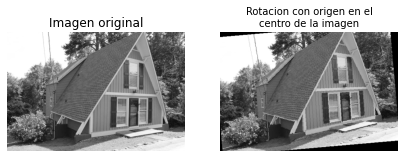

In [15]:
# Muestre las matrices correspondientes a las tres transformaciones
def matriz_traslacion(dx, dy):
    return np.array([[1, 0, dy],
                     [0, 1, dx],
                     [0, 0, 1]])

def matriz_rotacion(grados):
    theta = np.radians(grados)
    return np.array([[np.cos(theta), -np.sin(theta), 0],
                    [np.sin(theta),    np.cos(theta), 0],
                    [0,                0,             1]])


# Calcule la matriz de rotación en el centro como la composición de las tres transformaciones anteriores
alto, ancho = casa.shape
matriz_rot_centro = matriz_traslacion(ancho/2, alto/2) @ matriz_rotacion(-5) @ matriz_traslacion(-ancho/2, -alto/2)

# Aplique la transformación y muestre el resultado
casa_transformada = transformar(casa, matriz_rot_centro, tipo_interpolacion='vecino', color_de_fondo=0)

fig, ax = plt.subplots(1, 2,  figsize=(7,7))
ax[0].imshow(casa, cmap='gray')
ax[0].axis('off')
ax[0].set_title(f'Imagen original')
ax[1].imshow(casa_transformada, cmap='gray')
ax[1].axis('off')
ax[1].set_title(f'Rotacion con origen en el\ncentro de la imagen', fontsize=10)
plt.show()


#### Mostrar una transformación afin 

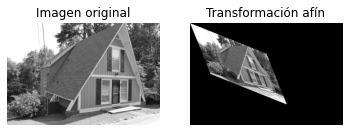

In [16]:
T = np.array([[0.5, 0.2, 0],
             [0.2, 0.5, 0],
             [0, 0, 1]])

casa_transformada = transformar(casa, T, tipo_interpolacion='vecino', color_de_fondo=0)

fig, ax = plt.subplots(1, 2)
ax[0].set_title(f'Imagen original')
ax[0].imshow(casa, cmap='gray')
ax[0].axis('off')

ax[1].set_title(f'Transformación afín')
ax[1].imshow(casa_transformada, cmap='gray')
ax[1].axis('off')
plt.show()

#### Mostrar una transformación proyectiva

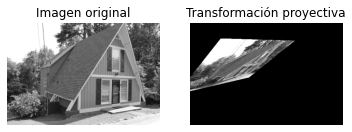

In [17]:
T = np.array([[1, -0.5, 100],
            [0.1, 0.9, 50],
            [0.0015, 0.0015, 1]])

casa_transformada = transformar(casa, T, tipo_interpolacion='vecino', color_de_fondo=0)

fig, ax = plt.subplots(1, 2)
ax[0].set_title(f'Imagen original')
ax[0].imshow(casa, cmap='gray')
ax[0].axis('off')

ax[1].set_title(f'Transformación proyectiva')
ax[1].imshow(casa_transformada, cmap='gray')
ax[1].axis('off')
plt.show()

### 3. Implementar el cálculo de una matriz de transformación proyectiva a partir de un conjunto de  4 o más puntos correspondientes


In [14]:
# Entradas:
#    puntosA   Nx2
#    puntosB   Nx2
#    con N>=4
# Salida
#    H         3x3

def calcular_homografia(puntosA, puntosB):

    num_ecuaciones = puntosA.shape[0]*2

    A = np.empty((num_ecuaciones, 8))
    b = np.empty((num_ecuaciones,1))


    for i in range(len(puntosA)):
        x, y = puntosA[i]
        u, v = puntosB[i]

        A[i*2] = [x, y, 1, 0, 0, 0, -x*u, -y*u]
        A[i*2+1] = [0, 0, 0, x, y, 1, -x*v, -y*v]

        b[i*2] = u
        b[i*2+1] = v

    H = np.linalg.lstsq(A, b, rcond=None)[0]
    H = np.append(H,[1])
    H = np.reshape(H, (3, 3))

    return H

#### Chequear la función implementada

In [19]:
# chequear la función calcularHomografía con un conjunto de puntos N=4
origen =  np.array([(0,0), (0,100), (100, 100), (100, 0)])
destino = np.array([(0,0), (0,100), (100, 50),  (100, 0)])
print('origen:\n', origen)
print('destino:\n', destino)

# calcular la homografía
H = calcular_homografia(origen, destino)

# aplicar a los puntos origen y verificar si el resultado son los puntos destino
print('Usando homografia:')
for punto in origen:
    x, y = punto
    u = H@np.array([x, y, 1])
    x_, y_, _ = u/u[2]
    print(f"({x}, {y}) -->, ({x_:0.2f}, {y_:0.2f})")

origen:
 [[  0   0]
 [  0 100]
 [100 100]
 [100   0]]
destino:
 [[  0   0]
 [  0 100]
 [100  50]
 [100   0]]
Usando homografia:
(0, 0) -->, (0.00, -0.00)
(0, 100) -->, (-0.00, 100.00)
(100, 100) -->, (100.00, 50.00)
(100, 0) -->, (100.00, -0.00)


In [20]:
# chequear la función calcularHomografía con un conjunto de puntos N>4
origen =  np.array([(0,0), (0,52), (0,100), (100, 100), (100, 0)])
destino = np.array([(0,0), (0,48), (0,100), (100, 50),  (100, 0)])
print('origen:\n', origen)
print('destino:\n', destino)


# calcular la homografía
H = calcular_homografia(origen, destino)


# aplicar a los puntos origen y verificar si el resultado es cercano a los puntos destino
print('Usando homografia:')
for punto in origen:
    x, y = punto
    u = H@np.array([x, y, 1])
    x_, y_, _ = u/u[2]
    print(f"({x}, {y}) -->, ({x_:0.2f}, {y_:0.2f})")

origen:
 [[  0   0]
 [  0  52]
 [  0 100]
 [100 100]
 [100   0]]
destino:
 [[  0   0]
 [  0  48]
 [  0 100]
 [100  50]
 [100   0]]
Usando homografia:
(0, 0) -->, (0.61, -1.07)
(0, 52) -->, (-0.02, 50.26)
(0, 100) -->, (-0.61, 98.81)
(100, 100) -->, (100.31, 50.00)
(100, 0) -->, (99.69, 0.00)


#### Aplicación: Incrustar la imagen "monalisa" en la imagen "casa" de forma que parezca pintada en el techo de la cabaña
Los puntos del techo pueden seleccionarse manualmente.  
Notar que, una vez calculada la homografía, la imagen resultado puede generarse mediante una función prácticamente igual a la función transformar implementada en (1).

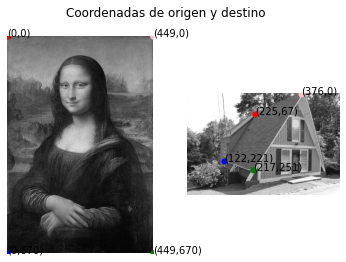

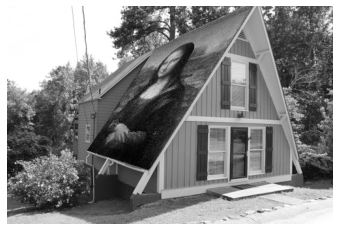

In [21]:
casa = cv2.imread(os.path.join(dir_base_imagenes, 'casa.jpg'), cv2.IMREAD_GRAYSCALE)
monalisa = cv2.imread(os.path.join(dir_base_imagenes, 'monalisa.jpg'), cv2.IMREAD_GRAYSCALE)

origen = np.array([(0,0), (0, 670), (449, 670), (449,0)])
destino =  np.array([(225, 67), (122, 221), (217, 251), (376, 0)])

fig, ax = plt.subplots(1, 2)
fig.suptitle('Coordenadas de origen y destino')
ax[0].imshow(monalisa, cmap='gray')
ax[0].axis('off')
color=['red', 'blue', 'green', 'pink']
for i, punto in enumerate(origen):
    x, y = punto
    ax[0].scatter(x, y, color=color[i], linewidths=0.5)
    ax[0].annotate(f'({x},{y})', (x, y))
ax[1].imshow(casa, cmap='gray')
ax[1].axis('off')
for i, punto in enumerate(destino):
    x, y = punto
    ax[1].scatter(x, y, color=color[i], linewidths=0.05)
    ax[1].annotate(f'({x},{y})', (x, y))
plt.show()

# calcular la homografía
H = calcular_homografia(origen, destino)

# Incrustrar monalisa en el techo de la casa
filas, columnas = casa.shape
incrustracion = np.empty((filas, columnas))
H_inv = np.linalg.inv(H)
for i in range(filas):
    for j in range(columnas):
        x, y = j, i
        x_, y_, w_ = H_inv @ [x, y, 1]
        punto = [y_/w_, x_/w_] #fila,columna
        incrustracion[i, j] = vecino(img=monalisa, punto=punto, color_de_fondo=casa[i,j])
plt.figure()
plt.axis('off')
plt.imshow(incrustracion, cmap='gray')
plt.show()


## Segmentación

### 4. Detección de líneas con la transformada de Hough

#### Implementar detección de líneas con la transformada de Hough.   
Se puede encontrar una buena explicación y pseudocódigo en los libros de [Burger & Burge](https://books.google.com.uy/books?id=YpzWCwAAQBAJ&printsec=frontcover#v=onepage&q&f=false). 

#### Dibujo de líneas

In [6]:

def plot_lineas_hough(fig, img, L):
    '''
    Parameters
    ----------
    fig : Numero de la figura de matplotlib donde se plotean las líneas
    L :   [[rho, theta, votos], [rho, theta, votos], .....]
          Lista de rectas detectadas con la función lineas_hough

    Retorna
    -------
    Nada

    '''

    fig.imshow(img, cmap='gray')

    x0 = img.shape[1] / 2
    y0 = img.shape[0] / 2

    colores = plt.cm.viridis(np.linspace(0, 1, len(L)))

    for i, linea in enumerate(L):
        rho, theta, _ = linea

        theta = -np.pi/2 + theta

        xr = x0 + rho*np.cos(theta)
        yr = y0 - rho*np.sin(theta)

        fig.axline((xr, yr), slope = np.tan(-theta + np.pi/2), color=colores[i])

    fig.set_ylim([img.shape[0]-1, 0])
    fig.set_xlim([0, img.shape[1]-1])


#### Mostrar el funcionamiento de plot_lineas_hough para distintos valores theta-rho
Notar que se puede implementar y probar **plot_lineas_hough** antes de implementar **lineas_hough**.  
Se sugiere dejar andando correctamente **plot_lineas_hough** primero. Esto permitirá luego probar rápidamente los resultados de **lineas_hough**.
  

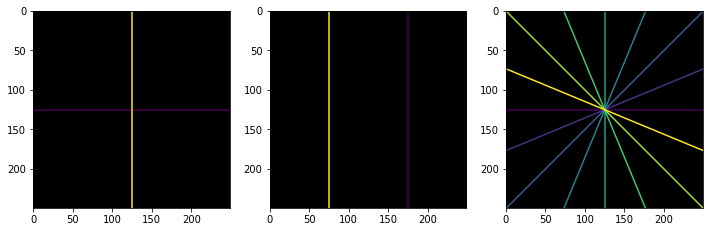

In [23]:
# Imagen vacía a plottear
zeros = np.zeros((250,250))

# líneas vertical y horizontal que pasan por la mitad de la imagen
lineas = [[0,0,1], [0,np.pi/2,3]]

# líneas horizontales con rho 50
lineas2 = [[50, np.pi/2, 1], [50, 3*np.pi/2 ,2]]

# lineas separadas por un ángulo de pi/8 radianes
lineas3 = [[0,0,5], [0,np.pi/8,1],

           [0,np.pi/4,8], [0,3*np.pi/8,6],

           [0,np.pi/2,5], [0,5*np.pi/8,4],

           [0,3*np.pi/4,100], [0,7*np.pi/8,6]
           ]

# Inicializar figura
fig, ax = plt.subplots(1, 3, figsize=(12,8))

# Plot lineas
plot_lineas_hough(ax[0], zeros, lineas)

# Plot lineas2
plot_lineas_hough(ax[1], zeros, lineas2)

# Plot lineas3
plot_lineas_hough(ax[2], zeros, lineas3)

#### Detección de líneas

In [7]:
def is_local_max(A,i,j):
    max = 0
    for k in range(i-1, i+2):
        for l in range(j-1, j+2):
            try:
                if max < A[k,l]:
                    max = A[k,l]
            except:
                pass
    return (max <= A[i,j])


def lineas_hough(I, m, n, minimo_votos, debug=False):
    '''
    Detección de líneas mediante la Transformada de Hough

    Args
    ----
    I : imagen binaria (resultado de un detector de bordes por ejemplo)
    m, n : Enteros que determinan las dimensiones del acumulador
           m: cantidad de pasos en Theta
           n: cantidad de pasos en Rho
    minimo_votos : Cantidad mínima de votos que debe tener una recta
    debug : Booleano opcional. En caso de ser verdadero, se muestra la imagen del acumulador

    Returns
    -------
    L : [[rho, theta, votos], [theta, rho, votos], .....]
        Lista con las rectas detectadas donde cada elemento de la lista es una terna [theta, rho, votos]
        La lista está ordenada en forma decreciente en la cantidad de votos

    '''
    u_c, v_c = I.shape[0]/2, I.shape[1]/2   # image center
    r_max = np.sqrt(u_c**2 + v_c**2)        # max radius is half the image diagonal
    delta_theta = np.pi / m                 # angular increment
    delta_r = 2 * r_max / n                     # radial increment

    Acc = np.zeros((m, n))                  # accumulator array

    for u in range(I.shape[0]):             # scan the image
        for v in range(I.shape[1]):
            if I[u,v] > 0:
                x, y = u-u_c, v-v_c                         # coordinate relative to center
                for i_theta in range(m):                    # angular index
                    theta = delta_theta * i_theta           # real angle
                    r = x*np.cos(theta) + y*np.sin(theta)   # real radius
                    i_r = int(n/2) + int(np.round(r/delta_r))    # radial index
                    if 0 <= i_r <= Acc.shape[1]-1:
                        Acc[i_theta, i_r] += 1

    L = []
    for i in range(Acc.shape[0]):
        for j in range(Acc.shape[1]):
            if (Acc[i,j] >= minimo_votos) and is_local_max(Acc, i, j):
                th = delta_theta * i
                r = (j - n/2) * delta_r
                a = Acc[i,j]
                L.append([r, th, a])
    L.sort(key=lambda x: x[2], reverse=True)

    if debug:
        plt.figure()
        plt.imshow(Acc)

    return L

#### Mostrar el funcionamiento de lineas_hough
Para imágenes artificiales sencillas que se construirán,    
a) detectar líneas  
b) mostrar el acumulador y plotear las rectas    
c) relacionar el contenido del acumulador con las rectas correspondientes    

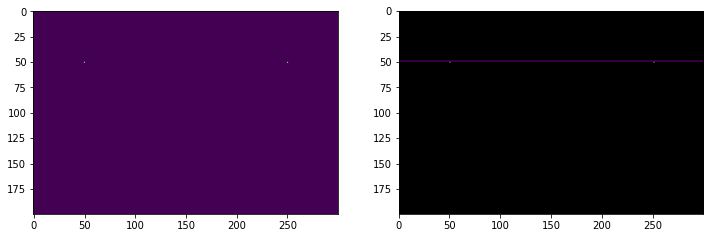

In [25]:
#Ejemplo 1
I = np.zeros((200,300), dtype=np.uint8)
I[50,50]=255
I[50,250]=255

L = lineas_hough(I,100,100, minimo_votos=2, debug=False)

fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(I)
plot_lineas_hough(ax[1], I, L)


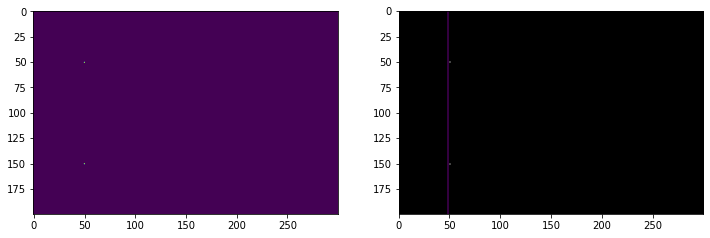

In [26]:
#Ejemplo 2
I = np.zeros((200,300), dtype=np.uint8)
I[50,50]=255
I[150,50]=255

L = lineas_hough(I,100,100, minimo_votos=2, debug=False)
fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(I)
plot_lineas_hough(ax[1], I, L)

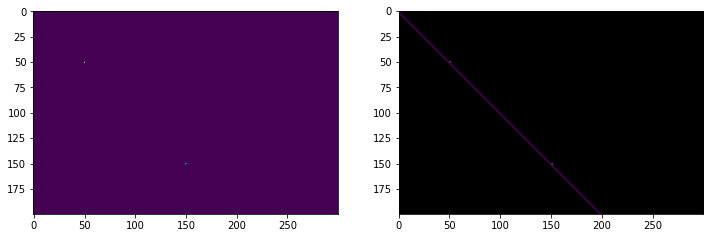

In [27]:
#Ejemplo 3
I = np.zeros((200,300), dtype=np.uint8)
I[50,50]=255
I[150,150]=255

L = lineas_hough(I,100,100, minimo_votos=2, debug=False)

fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(I)
plot_lineas_hough(ax[1], I, L)

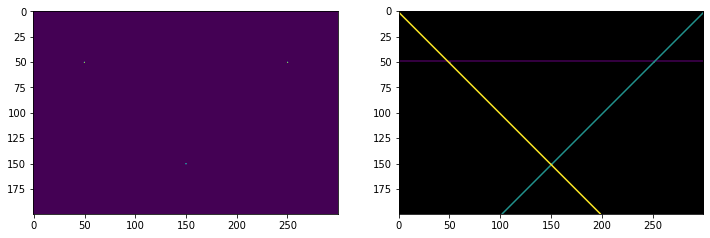

In [28]:
# Ejemplo 4
I = np.zeros((200,300), dtype=np.uint8)
I[50,50]=255
I[50,250]=255
I[150,150]=255

L = lineas_hough(I,100,100, minimo_votos=2, debug=False)

fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].imshow(I)
plot_lineas_hough(ax[1], I, L)


#### Mostrar el funcionamiento de lineas_hough sobre la imagen trapecio.png
Comentar resultados al variar la resolución en el espacio de parámetros (m y n en la función lineas_hough)

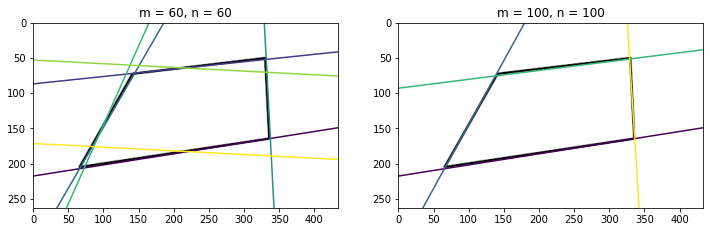

In [29]:
trapecio = cv2.imread(os.path.join(dir_base_imagenes, 'trapecio.png'), cv2.IMREAD_GRAYSCALE)
trapecio_inv = 255 - trapecio.copy()

L1 = lineas_hough(trapecio_inv,60,60, minimo_votos=200, debug=False)
L2 = lineas_hough(trapecio_inv,100,100, minimo_votos=500, debug=False)

fig, ax = plt.subplots(1, 2, figsize=(12,12))
ax[0].set_title("m = 60, n = 60")
plot_lineas_hough(ax[0], trapecio, L1)
ax[1].set_title("m = 100, n = 100")
plot_lineas_hough(ax[1], trapecio, L2)

Se puede observar que al aumentar el entramado de rho y theta, el resultado es más preciso

### 5. Aplicación: Determinar en forma automática  la ubicación de un tablero de ajedrez
a) Detectar líneas   
b) Determinar la ubicación del tablero   
c) Rectificar la imagen del tablero. Obtener una imagen del tablero como visto desde arriba   

Mostrar resultados con todas las imágenes de tableros


In [9]:
tablero_vacio_1 = cv2.imread(os.path.join(dir_base_imagenes, 'tableros/tablero_vacio_01.jpg'), cv2.IMREAD_GRAYSCALE)
tablero_vacio_2 = cv2.imread(os.path.join(dir_base_imagenes, 'tableros/tablero_vacio_02.jpg'), cv2.IMREAD_GRAYSCALE)
tablero_vacio_3 = cv2.imread(os.path.join(dir_base_imagenes, 'tableros/tablero_vacio_03.jpg'), cv2.IMREAD_GRAYSCALE)
tablero_piezas_1 = cv2.imread(os.path.join(dir_base_imagenes, 'tableros/tablero_con_piezas_01.png'), cv2.IMREAD_GRAYSCALE)
tablero_piezas_2 = cv2.imread(os.path.join(dir_base_imagenes, 'tableros/tablero_con_piezas_02.jpg'), cv2.IMREAD_GRAYSCALE)
tablero_piezas_3 = cv2.imread(os.path.join(dir_base_imagenes, 'tableros/tablero_con_piezas_03.jpg'), cv2.IMREAD_GRAYSCALE)

In [12]:
def hallar_lineas_tablero(L):
    L = np.asarray(L)
    rhos = L[:, 0]
    thetas = L[:, 1]

    # hallar los dos thetas mas frecuentes
    theta_counts = Counter(thetas)
    most_common_thetas = theta_counts.most_common(2)
    theta_1 = most_common_thetas[0][0]
    theta_2 = most_common_thetas[1][0]

    tolerance = (theta_1 + theta_2)/2

    # filtrar los valores cercanos a theta_1
    group1_mask = np.abs(thetas - theta_1) < tolerance
    rhos_group1 = rhos[group1_mask]
    thetas_group1 = thetas[group1_mask]

    # filtrar los valores cercanos a theta_2
    group2_mask = np.abs(thetas - theta_2) < tolerance
    rhos_group2 = rhos[group2_mask]
    thetas_group2 = thetas[group2_mask]

    # calcular los valores máximos y mínimos de rho para cada grupo
    rho_max_group1 = np.max(rhos_group1)
    rho_min_group1 = np.min(rhos_group1)
    theta_max_group1 = np.max(thetas_group1)
    theta_min_group1 = np.min(thetas_group1)

    rho_max_group2 = np.max(rhos_group2)
    rho_min_group2 = np.min(rhos_group2)
    theta_max_group2 = np.max(thetas_group2)
    theta_min_group2 = np.min(thetas_group2)

    L_bordes = [
        [rho_max_group1, theta_max_group1, 0],
        [rho_min_group1, theta_min_group1, 0],
        [rho_max_group2, theta_max_group2, 0],
        [rho_min_group2, theta_min_group2, 0],
    ]
    return L_bordes

def hough_to_cartesian(rho, theta, img_height, img_width):
    """
    Devuelve la pendiente m y la ordenada en el origen n de la recta, en coordenadas cartesianas
    """
    x0, y0 = img_width/2, img_height/2

    theta = -np.pi/2 + theta

    xr = x0 + rho*np.cos(theta)
    yr = y0 - rho*np.sin(theta)

    m = np.tan(-theta + np.pi/2)

    #### yr = m xr + n -> n = yr - m xr
    n = yr - m * xr

    return m, n

def interseccon_dos_rectas(m1, n1, m2, n2):
    """
    Devuelve las coordenadas x, y de la interseccion entre dos rectas de pendientes m1 y m2 y ordenadas en el origen n1 y n2
    """
    x = (n2 - n1) / (m1 - m2)
    y = m1 * x + n1
    return x, y

def hallar_vertices_tablero(L_bordes, img_height, img_width):
    """
    A partir del L con los las 4 lineas borde del tablero, devuelve los 4 puntos de interseccion
    """
    lines_cartesian = [hough_to_cartesian(rho, theta, img_height, img_width) for rho, theta, _ in L_bordes]

    m0, n0 = lines_cartesian[0]
    m1, n1 = lines_cartesian[1]
    m2, n2 = lines_cartesian[2]
    m3, n3 = lines_cartesian[3]
    x0, y0 = interseccon_dos_rectas(m0, n0, m2, n2)
    x1, y1 = interseccon_dos_rectas(m0, n0, m3, n3)
    x2, y2 = interseccon_dos_rectas(m1, n1, m2, n2)
    x3, y3 = interseccon_dos_rectas(m1, n1, m3, n3)

    return [(x0, y0), (x1, y1), (x2, y2), (x3, y3)]


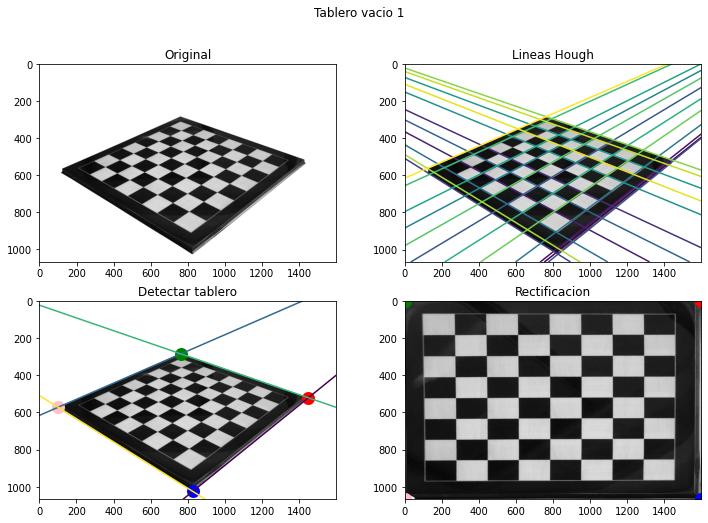

In [234]:
nombre = "Tablero vacio 1"
img = tablero_vacio_1

img_height, img_width = img.shape[0], img.shape[1]

img_hough = cv2.Canny(img, 50, 150, apertureSize=3)

m = 360
n = int(np.sqrt((img_hough.shape[0]/2)**2 + (img_hough.shape[1]/2)**2))
L = lineas_hough(img_hough, m, n, minimo_votos=500, debug=False)

L_bordes = hallar_lineas_tablero(L)
puntos_origen_tablero = hallar_vertices_tablero(L_bordes, img_height, img_width)
puntos_destino_tablero = [(img_width-1, 0), (img_width-1, img_height-1), (0,0), (0,img_height-1)]
H = calcular_homografia(np.array(puntos_origen_tablero), np.array(puntos_destino_tablero))
tablero_rectificado = transformar(img, H)


fig, ax = plt.subplots(2, 2, figsize=(12,8))
plt.suptitle(nombre)
ax[0,0].set_title("Original")
ax[0,0].imshow(img, cmap='gray')
ax[0,1].set_title("Lineas Hough")
plot_lineas_hough(ax[0,1], img, L)
ax[1,0].set_title("Detectar tablero")
plot_lineas_hough(ax[1,0], img, L_bordes)
color=['red', 'blue', 'green', 'pink']
for i, punto in enumerate(puntos_origen_tablero):
    x, y = punto
    ax[1,0].scatter(x, y, color=color[i], linewidths=7)
ax[1,1].set_title("Rectificacion")
ax[1,1].imshow(tablero_rectificado, cmap='gray')
for i, punto in enumerate(puntos_destino_tablero):
    x, y = punto
    ax[1,1].scatter(x, y, color=color[i], linewidths=7)
plt.show()

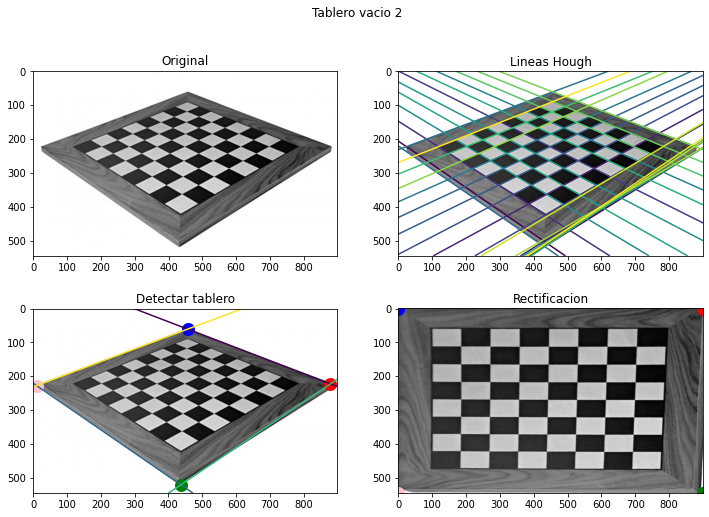

In [249]:
nombre = "Tablero vacio 2"
img = tablero_vacio_2

img_height, img_width = img.shape[0], img.shape[1]

img_hough = cv2.Canny(img, 50, 150, apertureSize=3)

m = 360
n = int(np.sqrt((img_hough.shape[0]/2)**2 + (img_hough.shape[1]/2)**2))
L = lineas_hough(img_hough, m, n, minimo_votos=300, debug=False)

L_bordes = hallar_lineas_tablero(L)
puntos_origen_tablero = hallar_vertices_tablero(L_bordes, img_height, img_width)
puntos_destino_tablero = [(img_width-1, 0), (0,0), (img_width-1, img_height-1), (0,img_height-1)]
H = calcular_homografia(np.array(puntos_origen_tablero), np.array(puntos_destino_tablero))
tablero_rectificado = transformar(img, H)


fig, ax = plt.subplots(2, 2, figsize=(12,8))
plt.suptitle(nombre)
ax[0,0].set_title("Original")
ax[0,0].imshow(img, cmap='gray')
ax[0,1].set_title("Lineas Hough")
plot_lineas_hough(ax[0,1], img, L)
ax[1,0].set_title("Detectar tablero")
plot_lineas_hough(ax[1,0], img, L_bordes)
color=['red', 'blue', 'green', 'pink']
for i, punto in enumerate(puntos_origen_tablero):
    x, y = punto
    ax[1,0].scatter(x, y, color=color[i], linewidths=7)
ax[1,1].set_title("Rectificacion")
ax[1,1].imshow(tablero_rectificado, cmap='gray')
for i, punto in enumerate(puntos_destino_tablero):
    x, y = punto
    ax[1,1].scatter(x, y, color=color[i], linewidths=7)
plt.show()

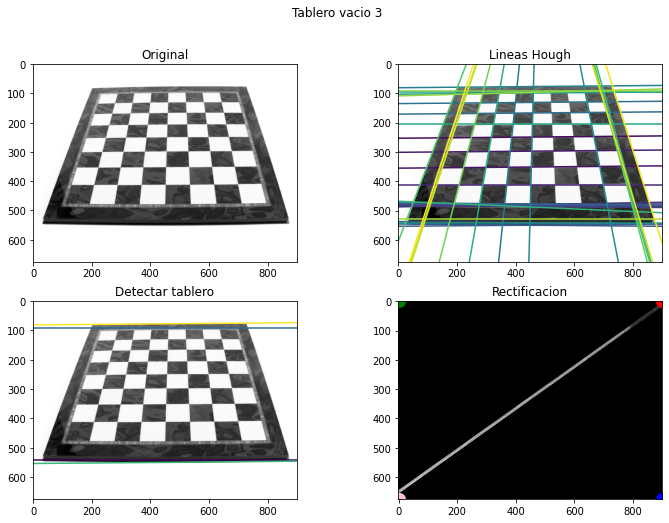

In [ ]:
nombre = "Tablero vacio 3"
img = tablero_vacio_3

img_height, img_width = img.shape[0], img.shape[1]

img_hough = cv2.Canny(img, 50, 150, apertureSize=3)

m = 360
n = int(np.sqrt((img_hough.shape[0]/2)**2 + (img_hough.shape[1]/2)**2))
L = lineas_hough(img_hough, m, n, minimo_votos=200, debug=False)

L_bordes = hallar_lineas_tablero(L)
puntos_origen_tablero = hallar_vertices_tablero(L_bordes, img_height, img_width)
puntos_destino_tablero = [(img_width-1, 0), (img_width-1, img_height-1), (0,0), (0,img_height-1)]
H = calcular_homografia(np.array(puntos_origen_tablero), np.array(puntos_destino_tablero))
tablero_rectificado = transformar(img, H)


fig, ax = plt.subplots(2, 2, figsize=(12,8))
plt.suptitle(nombre)
ax[0,0].set_title("Original")
ax[0,0].imshow(img, cmap='gray')
ax[0,1].set_title("Lineas Hough")
plot_lineas_hough(ax[0,1], img, L)
ax[1,0].set_title("Detectar tablero")
plot_lineas_hough(ax[1,0], img, L_bordes)
color=['red', 'blue', 'green', 'pink']
for i, punto in enumerate(puntos_origen_tablero):
    x, y = punto
    ax[1,0].scatter(x, y, color=color[i], linewidths=7)
ax[1,1].set_title("Rectificacion")
ax[1,1].imshow(tablero_rectificado, cmap='gray')
for i, punto in enumerate(puntos_destino_tablero):
    x, y = punto
    ax[1,1].scatter(x, y, color=color[i], linewidths=7)
plt.show()

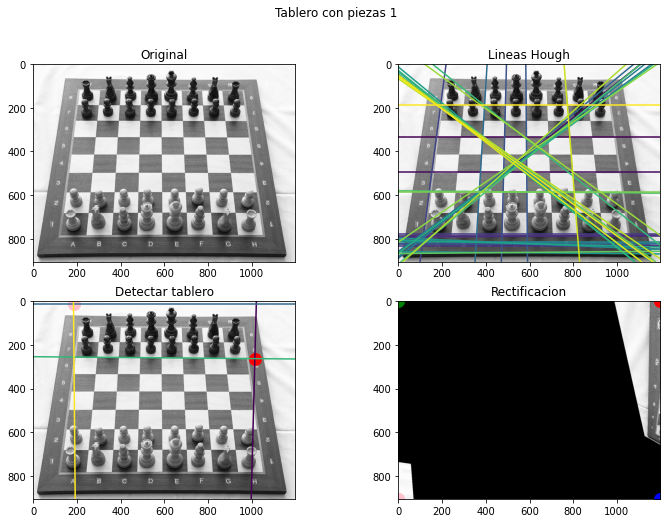

In [22]:
nombre = "Tablero con piezas 1"
img = tablero_piezas_1

img_height, img_width = img.shape[0], img.shape[1]

img_hough = cv2.Canny(img, 50, 150, apertureSize=3)

m = 360
n = int(np.sqrt((img_hough.shape[0]/2)**2 + (img_hough.shape[1]/2)**2))
L = lineas_hough(img_hough, m, n, minimo_votos=650, debug=False)

L_bordes = hallar_lineas_tablero(L)
puntos_origen_tablero = hallar_vertices_tablero(L_bordes, img_height, img_width)
puntos_destino_tablero = [(img_width-1, 0), (img_width-1, img_height-1), (0,0), (0,img_height-1)]
H = calcular_homografia(np.array(puntos_origen_tablero), np.array(puntos_destino_tablero))
tablero_rectificado = transformar(img, H)


fig, ax = plt.subplots(2, 2, figsize=(12,8))
plt.suptitle(nombre)
ax[0,0].set_title("Original")
ax[0,0].imshow(img, cmap='gray')
ax[0,1].set_title("Lineas Hough")
plot_lineas_hough(ax[0,1], img, L)
ax[1,0].set_title("Detectar tablero")
plot_lineas_hough(ax[1,0], img, L_bordes)
color=['red', 'blue', 'green', 'pink']
for i, punto in enumerate(puntos_origen_tablero):
    x, y = punto
    ax[1,0].scatter(x, y, color=color[i], linewidths=7)
ax[1,1].set_title("Rectificacion")
ax[1,1].imshow(tablero_rectificado, cmap='gray')
for i, punto in enumerate(puntos_destino_tablero):
    x, y = punto
    ax[1,1].scatter(x, y, color=color[i], linewidths=7)
plt.show()

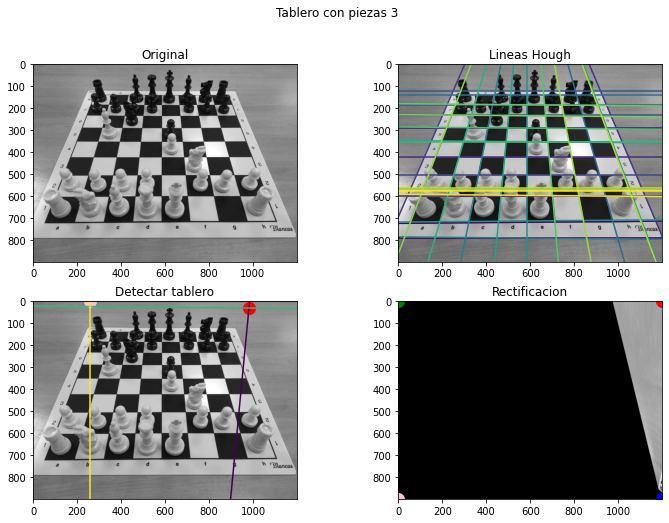

In [18]:
nombre = "Tablero con piezas 3"
img = tablero_piezas_3

img_height, img_width = img.shape[0], img.shape[1]

img_hough = cv2.Canny(img, 50, 150, apertureSize=3)

m = 360
n = int(np.sqrt((img_hough.shape[0]/2)**2 + (img_hough.shape[1]/2)**2))
L = lineas_hough(img_hough, m, n, minimo_votos=300, debug=False)

L_bordes = hallar_lineas_tablero(L)
puntos_origen_tablero = hallar_vertices_tablero(L_bordes, img_height, img_width)
puntos_destino_tablero = [(img_width-1, 0), (img_width-1, img_height-1), (0,0), (0,img_height-1)]
H = calcular_homografia(np.array(puntos_origen_tablero), np.array(puntos_destino_tablero))
tablero_rectificado = transformar(img, H)


fig, ax = plt.subplots(2, 2, figsize=(12,8))
plt.suptitle(nombre)
ax[0,0].set_title("Original")
ax[0,0].imshow(img, cmap='gray')
ax[0,1].set_title("Lineas Hough")
plot_lineas_hough(ax[0,1], img, L)
ax[1,0].set_title("Detectar tablero")
plot_lineas_hough(ax[1,0], img, L_bordes)
color=['red', 'blue', 'green', 'pink']
for i, punto in enumerate(puntos_origen_tablero):
    x, y = punto
    ax[1,0].scatter(x, y, color=color[i], linewidths=7)
ax[1,1].set_title("Rectificacion")
ax[1,1].imshow(tablero_rectificado, cmap='gray')
for i, punto in enumerate(puntos_destino_tablero):
    x, y = punto
    ax[1,1].scatter(x, y, color=color[i], linewidths=7)
plt.show()

## Regiones  

### 6. Implementar el etiquetado de regiones de una imagen binaria

In [2]:
def agregar_equivalencia(equivalencias:list, num1, num2):
    """
    Agrego la equivalencia (num1, num2)

    Args:
        equivalencias (list): Lista de sets de equivalencias. Ejemplo [{1, 2, 4}, {5, 6}]
        num1 (int)
        num2 (int)

    Returns:
        lista de quivalencias actualizada
    """
    # si num1 pertenece a set_num1 y num2 a set_num2 y set_num1 != set_num2
    # entonces me tomo la union de set_num1 y set_num2
    set_num1 = None
    set_num2 = None
    for equivalencia in equivalencias:
        if num1 in equivalencia:
            set_num1 = equivalencia
        if num2 in equivalencia:
            set_num2 = equivalencia
    if (set_num1 and set_num2) and (set_num1 != set_num2):
        equivalencias.remove(set_num1)
        equivalencias.remove(set_num2)
        equivalencias.append(set_num1.union(set_num2))
        return equivalencias

    # si no hay ninguna equivalencia aun, creo la primera
    if equivalencias == []:
        equivalencias.append({num1, num2})

    # si ya hay equivalencias existentes y num1 ó num2 ya pertence a un conjunto
    # entonces el que no pertenecía lo incluyo en dicho conjunto
    else:
        pertenece_a_grupo_existente = False
        for equivalencia in equivalencias:
            if (num1 in equivalencia) and (num2 not in equivalencia):
                equivalencia.add(num2)
                pertenece_a_grupo_existente = True
            elif (num1 not in equivalencia) and (num2 in equivalencia):
                equivalencia.add(num1)
                pertenece_a_grupo_existente = True
            elif (num1 in equivalencia) and (num2 in equivalencia):
                pertenece_a_grupo_existente = True
        # si, ni num1 ni num2 pertenecian a ningunas de las equivalencias
        # entonces creo una equivalencia nueva
        if not pertenece_a_grupo_existente:
            equivalencias.append({num1, num2})
    return equivalencias

def generar_map_equivalencias(equivalencias:list):
    map_equivalencias = {}
    for equivalencia in equivalencias:
        minimo = min(equivalencia)

        equivalencia_list = list(equivalencia)
        equivalencia_list.remove(minimo)

        for elemento in equivalencia_list:
            map_equivalencias[elemento] = minimo
        map_equivalencias[minimo] = minimo

    return map_equivalencias


def etiquetar(I, conectividad=8):
    I_etiquetada = I.copy()
    equivalencias = [] # list of sets
    N_label = 2

    for i in range(1, I_etiquetada.shape[0]):
        for j in range(1, I_etiquetada.shape[1]):

            A = I_etiquetada[i-1,j-1]
            B = I_etiquetada[i-1,j]
            C = I_etiquetada[i,j-1]
            M = I_etiquetada[i,j]

            if M != 0:
                if A > 0:
                    I_etiquetada[i,j] = A
                elif (B > 0) and (C == 0):
                    I_etiquetada[i,j] = B
                elif (B == 0) and (C > 0):
                    I_etiquetada[i,j] = C
                elif (B > 0) and (C > 0):
                    I_etiquetada[i,j] = C
                    equivalencias = agregar_equivalencia(equivalencias, C, B)
                else:
                    I_etiquetada[i,j] = N_label
                    N_label = N_label + 1
            else:
                if (B > 0) and (C > 0) and (B != C):
                    equivalencias = agregar_equivalencia(equivalencias, B, C)

    map_equivalencias = generar_map_equivalencias(equivalencias)
    for i in range(1, I_etiquetada.shape[0]):
        for j in range(1, I_etiquetada.shape[1]):
            if I_etiquetada[i,j] in map_equivalencias:
                I_etiquetada[i,j] = map_equivalencias[I_etiquetada[i,j]]

    return I_etiquetada

#### Verificar el correcto funcionamiento con la imagen “para_etiquetar.bmp” (tiene 4 regiones negras con conectividad 8 vecinos sobre fondo blanco).

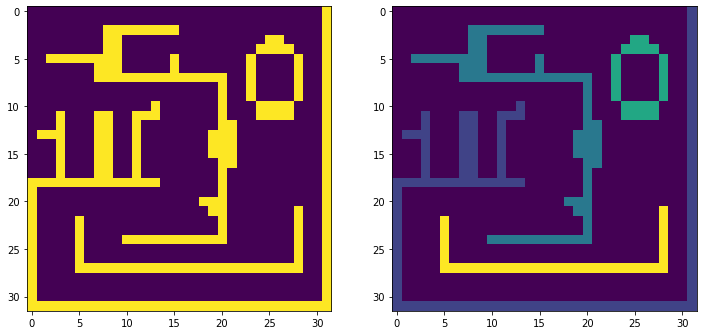

In [3]:
para_etiquetar = cv2.imread(os.path.join(dir_base_imagenes, 'para_etiquetar.bmp'), cv2.IMREAD_GRAYSCALE)

# pongo el fondo en 0 y las regiones en 1 para aplicar etiquetado
_, imagen_umbralizada = cv2.threshold(para_etiquetar, 128, 1, cv2.THRESH_BINARY)
img_binarizada = 1-imagen_umbralizada.copy()

img_etiquetada = etiquetar(img_binarizada, conectividad=8)

fig, ax = plt.subplots(1,2, figsize=(12,12))
ax[0].imshow(img_binarizada)
ax[1].imshow(img_etiquetada, vmin=0, vmax=5)
plt.show()

#### Aplicación: Para las imágenes globulos_01 y globulos_02
a) Preprocesar en caso de ser necesario con un filtrado adecuado en frecuencia   
b) Umbralizar  
c) Aplicar operaciones morfológicas adecuadas    
d) Etiquetar    
e) Devolver una imagen con las regiones identificadas y una lista de las regiones con sus propiedades (centroide, area, perímetro, circularidad)   


Glóbulos 1

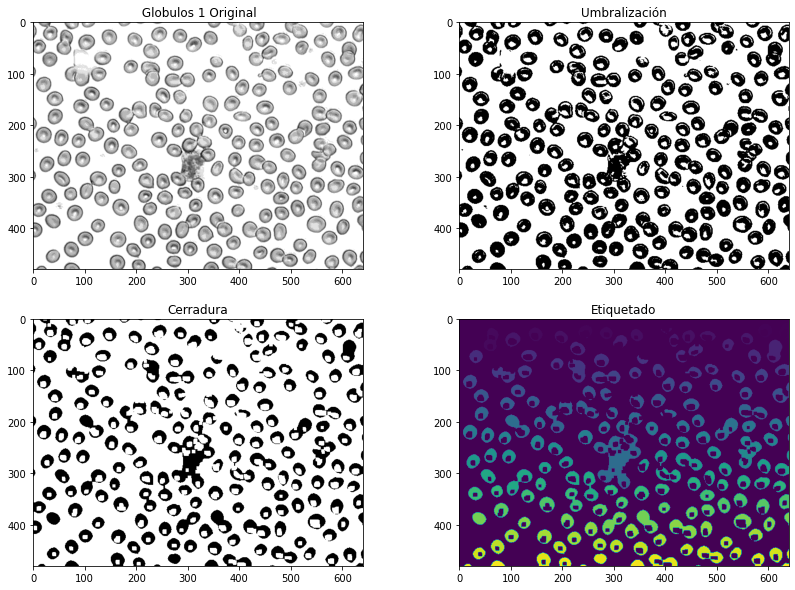

,label,area,perimeter,centroid-0,centroid-1,circularity
0,1,107,55.935029,18.532710,1.813084,0.429760
1,2,471,192.811183,16.639066,31.212314,0.159209
2,3,168,93.006097,5.279762,74.672619,0.244060
3,4,27,20.242641,3.296296,98.444444,0.828017
4,5,70,41.106602,4.714286,113.171429,0.520577


In [4]:
globulos_1 = cv2.imread(os.path.join(dir_base_imagenes, 'globulos_01.png'), cv2.IMREAD_GRAYSCALE)

# filtrado en frecuencia
globulos_1_fft = fftshift(fft2(globulos_1, shape=globulos_1.shape))
mask = np.zeros(globulos_1.shape, np.uint8)
cv2.circle(mask, (globulos_1.shape[1]//2 , globulos_1.shape[0]//2), 80, 1, -1)
globulos_1_filtrada_fft = globulos_1_fft * mask
globulos_1_filtrada = ifft2(globulos_1_filtrada_fft)

# umbralizar
_, globulos_1_umbr = cv2.threshold(globulos_1, 200, 255, cv2.THRESH_BINARY)

# cerradura
kernel = np.ones((3,3), np.uint8)
closed_image = cv2.erode(globulos_1_umbr, kernel, iterations=1)
closed_image = cv2.dilate(closed_image, np.ones((6,6), np.uint8), iterations=1)

# etiquetado
_, img_binarizada = cv2.threshold(closed_image, 128, 1, cv2.THRESH_BINARY)
img_binarizada = 1-img_binarizada.copy()
img_binarizada = img_binarizada.astype('int16')
img_etiquetada = etiquetar(img_binarizada)

fig, ax = plt.subplots(2,2, figsize=(14,10))
ax = ax.flatten()
ax[0].set_title(" Globulos 1 Original")
ax[0].imshow(globulos_1, cmap='gray')
ax[1].set_title("Umbralización")
ax[1].imshow(globulos_1_umbr, cmap='gray')
ax[2].set_title("Cerradura")
ax[2].imshow(closed_image, cmap='gray')
ax[3].set_title("Etiquetado")
ax[3].imshow(img_etiquetada)
plt.show()

# listar propiedades
labeled_image = measure.label(img_etiquetada, background=0, connectivity=2)
props = measure.regionprops_table(labeled_image, img_etiquetada,properties=['label', 'area','perimeter', 'centroid'])
data = pd.DataFrame(props)
data['circularity'] = (4 * np.pi * data['area']) / (data['perimeter'] ** 2)
data['circularity'].replace([np.inf, -np.inf], 0, inplace=True)
data.head()

Glóbulo 2

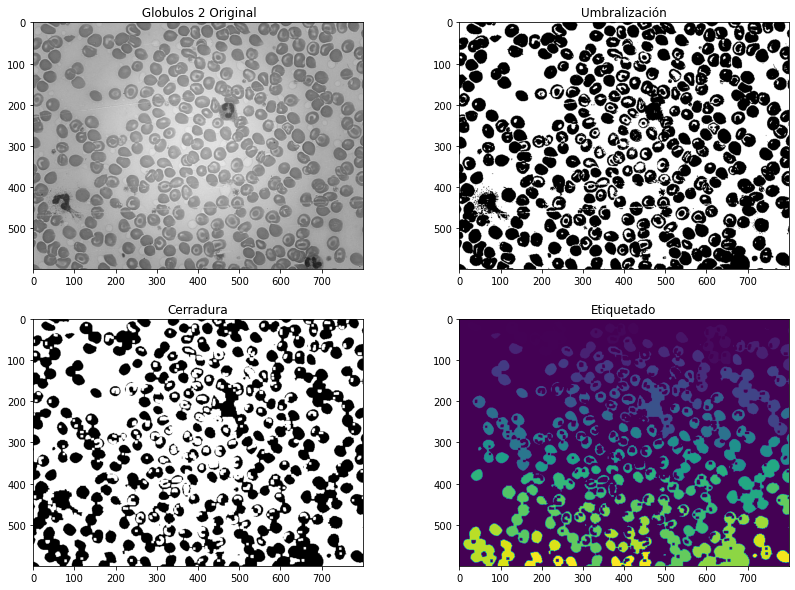

,label,area,perimeter,centroid-0,centroid-1,circularity
0,1,3,3.414214,0.333333,0.333333,3.234073
1,2,434,118.526912,4.311060,61.933180,0.388209
2,3,7,5.000000,0.000000,185.000000,3.518584
3,4,555,91.941125,9.353153,269.052252,0.825056
4,5,422,78.284271,7.933649,339.526066,0.865313


In [5]:
globulos_2 = cv2.imread(os.path.join(dir_base_imagenes, 'globulos_02.png'), cv2.IMREAD_GRAYSCALE)

# filtrado en frecuencia
globulos_2_fft = fftshift(fft2(globulos_2, shape=globulos_2.shape))
mask = np.zeros(globulos_2.shape, np.uint8)
cv2.circle(mask, (globulos_2.shape[1]//2 , globulos_2.shape[0]//2), 80, 1, -1)
globulos_2_filtrada_fft = globulos_2_fft * mask
globulos_2_filtrada = ifft2(globulos_2_filtrada_fft)

# Umbralizar con 170 en un circulo centrado de la imagen y con 150 en el resto
height, width = globulos_2.shape
radius = 200
center = (width // 2, height // 2)
mask = np.zeros((height, width), dtype=np.uint8)
cv2.circle(mask, center, radius, (255), thickness=-1)
ret1, thresh_circle = cv2.threshold(globulos_2, 170, 255, cv2.THRESH_BINARY)
ret2, thresh_rest = cv2.threshold(globulos_2, 150, 255, cv2.THRESH_BINARY)
thresh_circle_masked = cv2.bitwise_and(thresh_circle, thresh_circle, mask=mask)
mask_inv = cv2.bitwise_not(mask)
thresh_rest_masked = cv2.bitwise_and(thresh_rest, thresh_rest, mask=mask_inv)
globulos_2_umbr = cv2.bitwise_or(thresh_circle_masked, thresh_rest_masked)

# cerradura
kernel = np.ones((3,3), np.uint8)
closed_image = cv2.erode(globulos_2_umbr, kernel, iterations=1)
closed_image = cv2.dilate(closed_image, np.ones((6,6), np.uint8), iterations=1)

# etiquetado
_, img_binarizada = cv2.threshold(closed_image, 128, 1, cv2.THRESH_BINARY)
img_binarizada = 1-img_binarizada.copy()
img_binarizada = img_binarizada.astype('int16')
img_etiquetada = etiquetar(img_binarizada)

fig, ax = plt.subplots(2,2, figsize=(14,10))
ax = ax.flatten()
ax[0].set_title(" Globulos 2 Original")
ax[0].imshow(globulos_2, cmap='gray')
ax[1].set_title("Umbralización")
ax[1].imshow(globulos_2_umbr, cmap='gray')
ax[2].set_title("Cerradura")
ax[2].imshow(closed_image, cmap='gray')
ax[3].set_title("Etiquetado")
ax[3].imshow(img_etiquetada)
plt.show()

# listar propiedades
labeled_image = measure.label(img_etiquetada, background=0, connectivity=2)
props = measure.regionprops_table(labeled_image, img_etiquetada,properties=['label', 'area','perimeter', 'centroid'])
data = pd.DataFrame(props)
data['circularity'] = (4 * np.pi * data['area']) / (data['perimeter'] ** 2)
data['circularity'].replace([np.inf, -np.inf], 0, inplace=True)
data.head()